In [1]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import timeit
import json
import random
import pickle
import os
import datetime
from Sampling import sample_graph, get_modified_at_array

In [2]:
def truncate_playlists(playlists):
    new_playlists = list()
    for playlist in playlists:
        new_playlist = list({'name': f"{i['artist_name']} - {i['track_name']}", 'track_uri': i['track_uri'][len("spotify:"):]} for i in playlist['tracks'])
        new_playlists.append(new_playlist)
        
    return new_playlists

In [3]:
#CHANGE THIS DEPENDING ON YOUR DATA LOCATION
path = "DATA/"

In [4]:
G, test_playlists = sample_graph(verbose=True, path=path, testSplit=True)

15/15; time elapsed: 0.0 min 14.6 sec
Time elapsed: 0.0 min  14.636889799992787 sec
n:377001, m:1265170; 


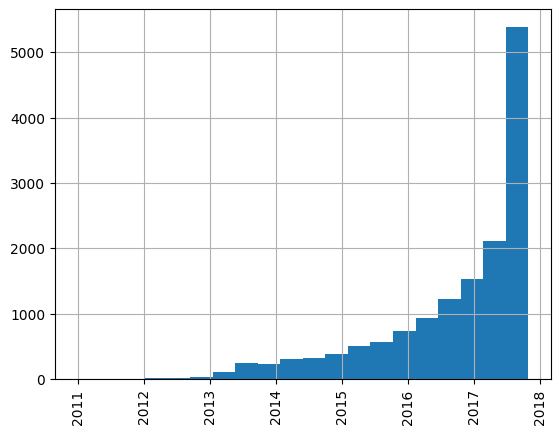

In [5]:
G_ser = get_modified_at_array(G,True)

In [7]:
len(test_playlists)

3016

In [8]:
#list({'name': f"{i['artist_name']} - {i['track_name']}", 'track_uri': i['track_uri'][len("spotify:"):]} for i in test_playlists[0]['tracks'])

In [9]:
test_playlists = truncate_playlists(test_playlists)

In [10]:
test_playlists[17]

[{'name': 'Carmen Twillie - Circle Of Life - From "The Lion King"/Soundtrack',
  'track_uri': 'track:0HU5JnVaKNTWf6GykV9Zn8'},
 {'name': 'Jason Weaver - I Just Can\'t Wait to Be King - From "The Lion King"/Soundtrack Version',
  'track_uri': 'track:0qxtQ8rf3W1nId3D2r0xH4'},
 {'name': 'Jeremy Irons - Be Prepared - From "The Lion King" / Soundtrack Version',
  'track_uri': 'track:34nxgXFCPzDphUJGuRsn10'},
 {'name': 'Nathan Lane - Hakuna Matata',
  'track_uri': 'track:5k3U0OGYBccHdKJJu3HrUN'},
 {'name': 'Joseph Williams - Can You Feel The Love Tonight',
  'track_uri': 'track:5E8yddtSG3sH4hw2SfwcgW'},
 {'name': 'Elton John - Circle Of Life - Remastered',
  'track_uri': 'track:1t055EdeL1r5DfORFy0UXX'},
 {'name': "Elton John - I Just Can't Wait To Be King",
  'track_uri': 'track:5QsEvml3ZEnISKBEaKueUy'},
 {'name': 'Elton John - Can You Feel The Love Tonight - Remastered',
  'track_uri': 'track:5KlCWDbatUCBhvN7ZwyeEF'},
 {'name': 'Cheryl Freeman - The Gospel Truth I / Main Titles - Hercules',

#### Random Walk method - proof of concept

In [6]:
from Algorithms import randWalkReccs

In [7]:
pd = random.sample(test_playlists[0],2)
personalization_vect = [i['track_uri'] for i in pd]

TypeError: Population must be a sequence.  For dicts or sets, use sorted(d).

In [ ]:
personalization_vect

['track:5B3y5P0D159qtws89K91mt', 'track:1LiNLlIrj5ZXO2RH9wct72']

In [14]:
start = timeit.default_timer()
num_iterations = 100*max(len(personalization_vect),10)
walk_steps = 12
results = randWalkReccs(G, num_iterations, walk_steps, personalization=personalization_vect)
stop = timeit.default_timer()
print('Time elapsed (minutes):', (stop - start)/60)  

NetworkXError: The node track:1LiNLlIrj5ZXO2RH9wct72 is not in the graph.

In [ ]:
rec_songs = filter(lambda x: str.startswith(str(x[0]), "track:"), results.items())
reccs = sorted(rec_songs, key=lambda x: x[1], reverse=True)
len(reccs)

3339

In [ ]:
predicted_playlist = [{'name': f"{G.nodes[reccs[i][0]]['artist_name']} - {G.nodes[reccs[i][0]]['track_name']}",'track_uri':reccs[i][0]} for i in range(len(test_playlists[0])-2)]

In [ ]:
len(set(p['track_uri'] for p in predicted_playlist).intersection(set(p['track_uri'] for p in test_playlists[0])))/len(test_playlists[0])

0.09815950920245399

#### Actual test run

In [8]:
G, test_playlists = sample_graph(verbose=True, path=path, testSplit=True)
test_playlists = truncate_playlists(test_playlists)

15/15; time elapsed: 0.0 min 14.6 sec
Time elapsed: 0.0 min  14.634233299992047 sec
n:378574, m:1267222; 


In [15]:
def evaluation_run(G,test_data,generator_function, different_starts = 1,persvec_lengths=5,walksteps=12,verbose=False):
    timer_start = timeit.default_timer()
    exceptions = 0
    global_counter = 0
    r_precisions = dict()
    
    #assert min([len(i) for i in test_data]) > persvec_lengths, "This will be a problem. Some playlists are shorter than the personalization vector."
    
    for i in range(1,persvec_lengths+1):
        r_precisions[i] = list()
    
    test_data = [i for i in test_data if len(i) > 9] ## in the challenge set file, the minimum number of playlist length ("num_tracks") is 10
    for test_playlist in test_data:
        for persvec_length in range(2,persvec_lengths+1): ## in the challenge set file, the minimum number of songs given ("num_samples") is 5 (if you ignore empty ones)
            for _ in range(different_starts):
                persvec = [track['track_uri'] for track in random.sample(test_playlist,persvec_length)]
                try:
                    res = generator_function(G, 100*max(len(persvec),10), walksteps, personalization=persvec)

                    rec_songs = filter(lambda x: str.startswith(str(x[0]), "track:"), res.items())
                    reccs = sorted(rec_songs, key=lambda x: x[1], reverse=True)

                    predicted_playlist = [reccs[i][0] for i in range(len(test_playlist)+persvec_length) if reccs[i][0] not in persvec]
                    
                    r_precision = len(set(predicted_playlist).intersection(set(p['track_uri'] for p in test_playlist)))/(len(test_playlist)-persvec_length)
                    r_precisions[persvec_length].append(r_precision)
                    
                    if verbose:
                        time_elapsed = timeit.default_timer() - timer_start
                        mins_elapsed = (time_elapsed)//60
                        secs_elapsed = time_elapsed % 60
                        print(f"{global_counter+exceptions+1}/{len(test_data)*persvec_lengths*different_starts}; time elapsed: {mins_elapsed:02.1f} min {secs_elapsed:02.1f} sec", end="\r")
                    
                    global_counter+=1
                except:
                    exceptions+=1
                    
    print(f"Number of exceptions (should be 0 in complete graph): {exceptions}")
    
    return r_precisions
    

In [20]:
np.sum([len(i) for i in test_playlists if len(i) > 9])

28862

In [16]:
statistics = evaluation_run(G, test_playlists, randWalkReccs, persvec_lengths=5,verbose=True)

Number of exceptions (should be 0 in complete graph): 384


In [17]:
from pprint import pprint
pprint([{'length of PV':t,'mean': np.mean(statistics[t]),'max': max(statistics[t]), 'std': np.std(statistics[t])} for t in statistics if len(statistics[t])>0])

[{'length of PV': 2,
  'max': 0.45454545454545453,
  'mean': 0.11595280748621416,
  'std': 0.0955895342470287},
 {'length of PV': 3,
  'max': 0.46153846153846156,
  'mean': 0.1262418090004838,
  'std': 0.09548178054071961},
 {'length of PV': 4,
  'max': 0.5,
  'mean': 0.13293823122648002,
  'std': 0.0993930698565212},
 {'length of PV': 5,
  'max': 0.52,
  'mean': 0.1336431523660927,
  'std': 0.09909916239802333}]


(array([50., 45., 33., 25., 10., 33., 15., 12.,  4.,  2.]),
 array([0.   , 0.038, 0.076, 0.114, 0.152, 0.19 , 0.228, 0.266, 0.304,
        0.342, 0.38 ]),
 <BarContainer object of 10 artists>)

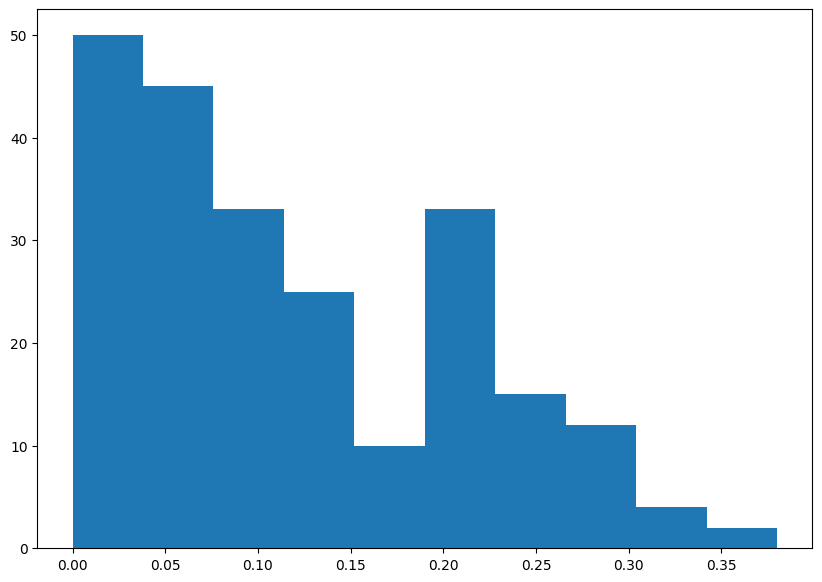

In [13]:
plt.figure(figsize=(10,7))
plt.hist(statistics[3])

(array([21., 29., 27., 38., 29., 34., 12., 15., 23., 16., 11., 15.,  9.,
        15.,  7.,  4.,  8.,  4.,  9.,  6.]),
 array([  5. ,  16.6,  28.2,  39.8,  51.4,  63. ,  74.6,  86.2,  97.8,
        109.4, 121. , 132.6, 144.2, 155.8, 167.4, 179. , 190.6, 202.2,
        213.8, 225.4, 237. ]),
 <BarContainer object of 20 artists>)

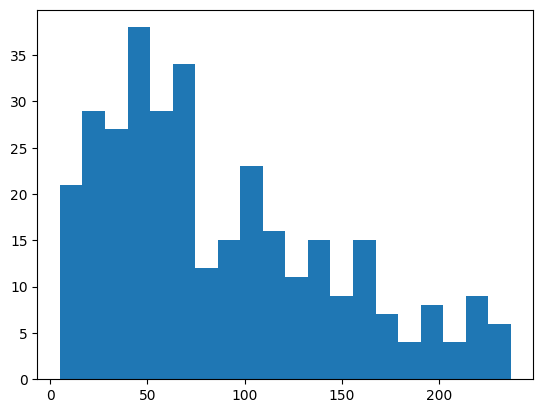

In [19]:
plt.hist([len(i) for i in test_playlists], 20)
